In [434]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import KFold
from xgboostlss.distributions import *
from xgboostlss.distributions.distribution_utils import DistributionClass
import warnings
warnings.filterwarnings('ignore')

In [435]:
X_train = pd.read_csv("X_trn.csv")
y_train = pd.read_csv("y_trn.csv")
X_test = pd.read_csv("X_test.csv")

In [436]:
X_train.describe()
# From 1974 to 2018

,year,age,prestg10,childs
count,31607.000000,31607.000000,31607.000000,31607.000000
mean,1996.149081,41.004303,43.811149,1.692125
std,12.496894,13.498038,13.093615,1.612093
min,1974.000000,18.000000,16.000000,0.000000
25%,1986.000000,30.000000,35.000000,0.000000
50%,1996.000000,39.000000,44.000000,2.000000
75%,2006.000000,51.000000,51.000000,3.000000
max,2018.000000,89.000000,80.000000,8.000000


In [437]:
X = X_train.copy()
X['y'] = y_train

In [438]:
for col in X_train.select_dtypes(include=["object"]).columns:
    print(f"{col}: {X_train[col].nunique()} unique values:")
    print(f"{X_train[col].unique()}\n")

occrecode: 11 unique values:
['Office and Administrative Support' 'Business/Finance' 'Service'
 'Production' 'Professional' 'Construction/Extraction' 'Sales'
 'Installation, Maintenance, and Repair' 'Transportation' 'Armed Forces'
 'Farming, Fishing, and Forestry']

wrkstat: 8 unique values:
['Full-Time' 'Part-Time' 'Temporarily Not Working' 'Housekeeper'
 'Unemployed, Laid Off' 'School' 'Retired' 'Other']

gender: 2 unique values:
['Female' 'Male']

educcat: 5 unique values:
['Bachelor' 'Graduate' 'Junior College' 'High School'
 'Less Than High School']

maritalcat: 5 unique values:
['Widowed' 'Married' 'Never Married' 'Separated' 'Divorced']



In [439]:
X_train["year"].unique()

array([2002, 2004, 1994, 1980, 2006, 2014, 1993, 2016, 1976, 2000, 1989,
       2012, 1978, 2018, 1975, 1986, 1998, 2008, 1991, 1974, 1996, 1988,
       1977, 1983, 2010, 1985, 1982, 1984, 1987, 1990], dtype=int64)

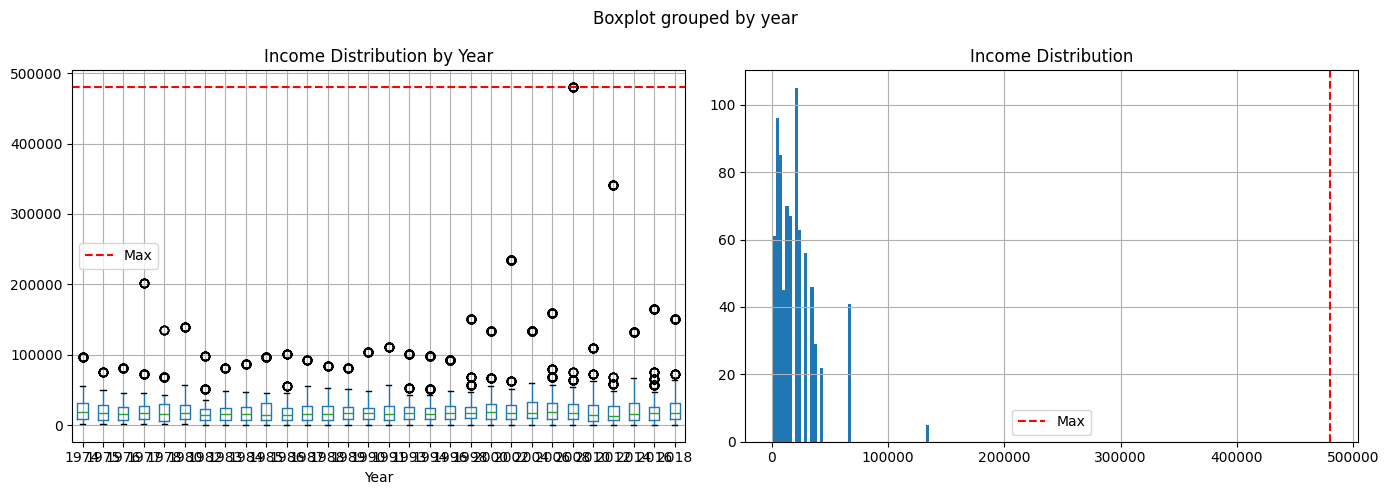

In [440]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

X.boxplot(column='y', by='year', ax=axes[0])
axes[0].axhline(y=480144.47, color='r', linestyle='--', label='Max')
axes[0].set_title('Income Distribution by Year')
axes[0].set_xlabel('Year')
axes[0].legend()

X[X['year'] == 1978]['y'].hist(bins=50, ax=axes[1])
axes[1].axvline(x=480144.47, color='r', linestyle='--', label='Max')
axes[1].set_title('Income Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

In [441]:
print(f"Number of unique values in y: {y_train.nunique().values[0]}")

Number of unique values in y: 602


In [442]:
X['max_income_year'] = X.groupby('year')['y'].transform('max')
X['is_max_income'] = (X['y'] == X['max_income_year']).astype(int)

max_observations = X[X['is_max_income'] == 1].copy()

print(f"Number of observations at the max: {len(max_observations)}")
print(f"\nNumber of observations at the max by year:")
count_per_year = max_observations.groupby('year').size().sort_values(ascending=False)
print(count_per_year)

Number of observations at the max: 986

Number of observations at the max by year:
year
2004    80
1996    79
2002    59
2014    51
1994    51
2006    45
1985    45
2018    41
1993    41
2016    41
2000    41
1976    35
1984    30
1998    30
1974    27
1990    27
1989    27
2008    26
2012    26
1983    25
1988    22
1987    22
1986    21
1980    19
2010    19
1991    17
1982    14
1975    12
1977     8
1978     5
dtype: int64


In [443]:
max_observations.drop(columns=['max_income_year', 'is_max_income'], inplace=True)

In [444]:
# Histogram of max incomes
# plt.hist(X[X["is_max_income"]==0]["y"], bins=30, color='red', alpha=0.3)
# plt.hist(X[X["is_max_income"]==1]["y"], bins=986, color='blue', alpha=0.8)

In [445]:
# X = X[X["is_max_income"]==0].drop(columns=['max_income_year', 'is_max_income'])
# X.reset_index(drop=True, inplace=True)

# y_train = X["y"]
# X_train = X.drop(columns=['y'])

In [446]:
X.drop(columns=['max_income_year', 'is_max_income'], errors='ignore', inplace=True)

In [447]:
np.argmax(X["y"])

78

In [448]:
X.loc[1674]

year                 1980
age                  37.0
occrecode           Sales
prestg10             58.0
childs                0.0
wrkstat         Full-Time
gender               Male
educcat       High School
maritalcat        Married
y                139297.0
Name: 1674, dtype: object

In [449]:
y_train.describe(percentiles=[.05, .10, .25, .50, .75, .90, .95, .99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
realrinc,31607.0,22244.905528,28276.641826,227.0,1450.0,3126.75,8156.0,16563.0,27171.0,42020.0,56160.0,134018.0,480144.472857


In [450]:
print(f"Skewness: {y_train.skew()}\nKurtosis: {y_train.kurtosis()}")

Skewness: realrinc    6.753899
dtype: float64
Kurtosis: realrinc    78.29784
dtype: float64


Text(0, 0.5, 'Frequency')

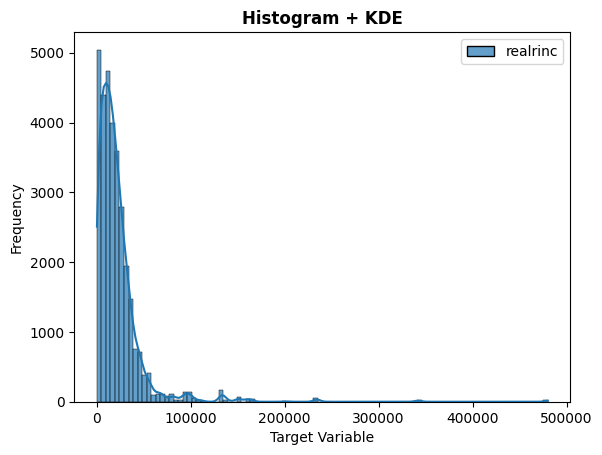

In [451]:
sns.histplot(y_train, bins=100, kde=True, alpha=0.7, color='skyblue')
plt.title('Histogram + KDE', fontsize=12, fontweight='bold')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')

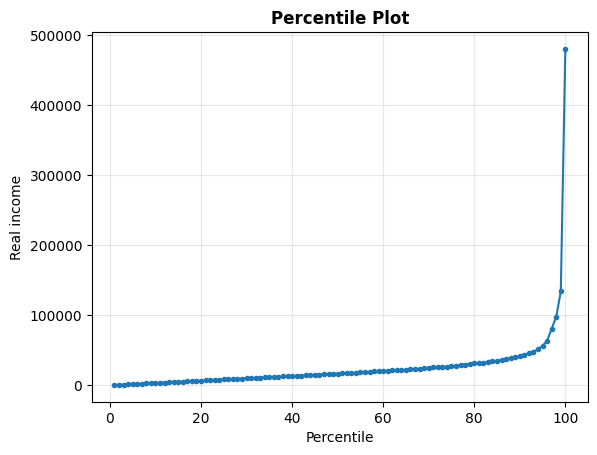

In [452]:
percentiles = np.arange(1, 101)
values = np.percentile(y_train, percentiles)
plt.plot(percentiles, values, marker='o', markersize=3)
plt.title('Percentile Plot', fontsize=12, fontweight='bold')
plt.xlabel('Percentile')
plt.ylabel('Real income')
plt.grid(True, alpha=0.3)

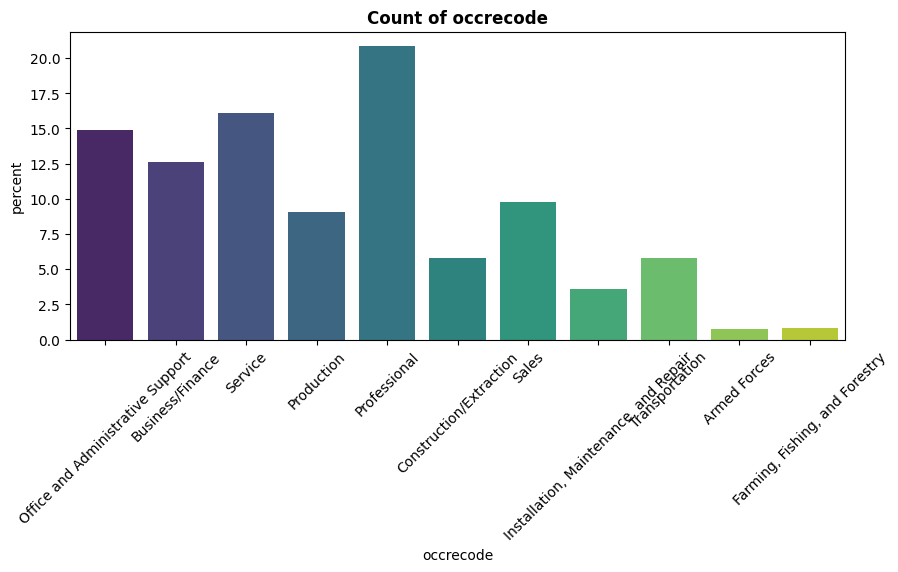

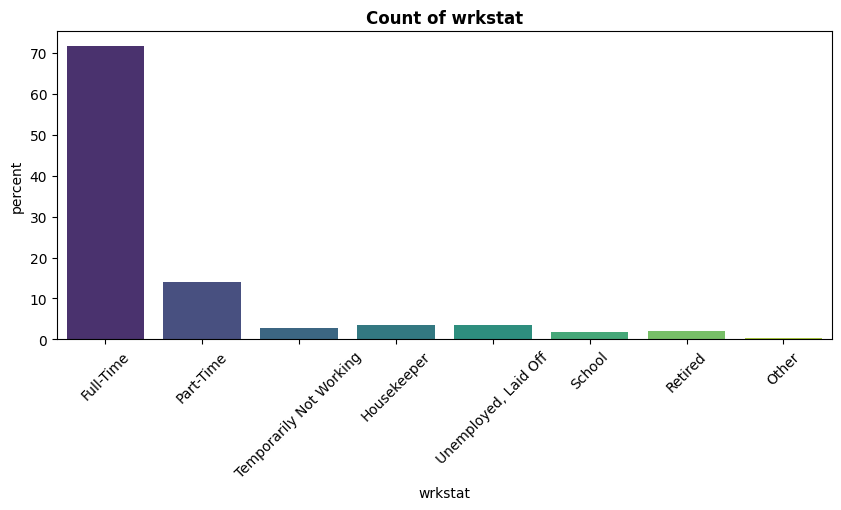

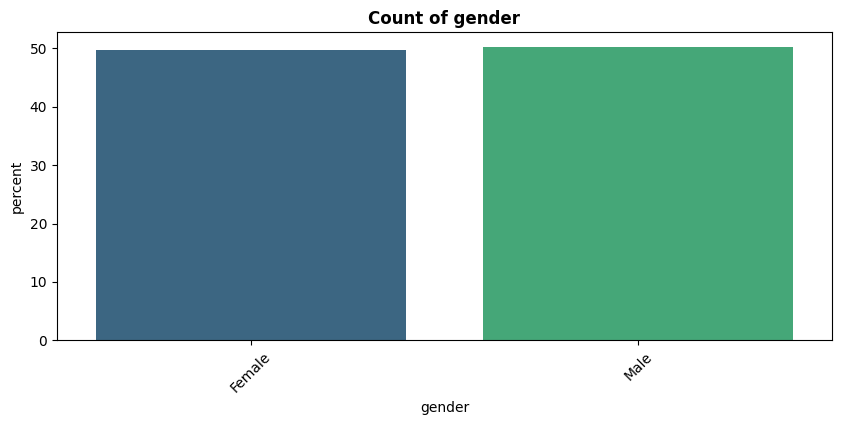

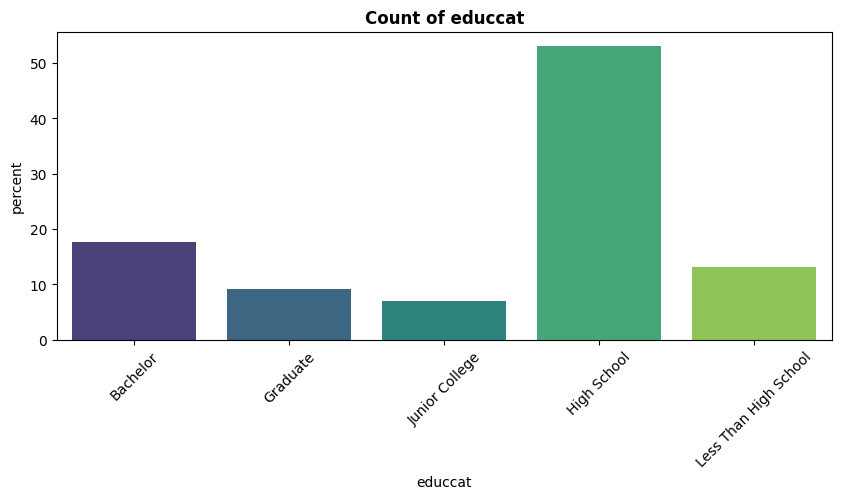

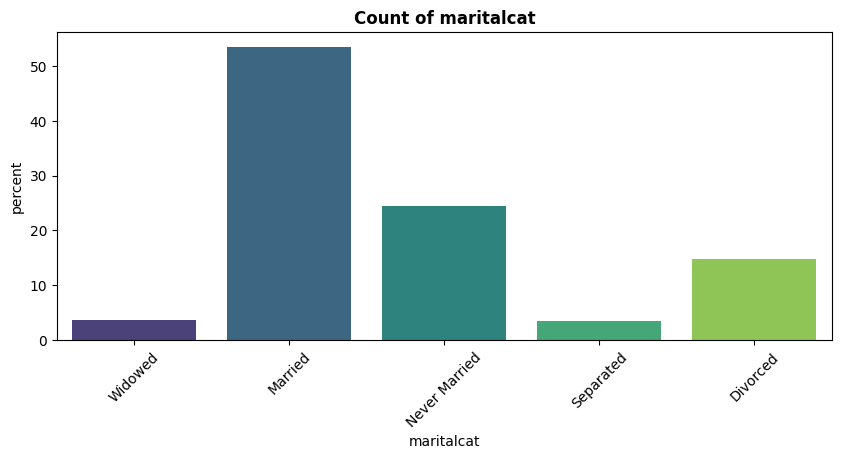

In [453]:
for col in X_train.select_dtypes(include=["object"]).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, data=X_train, palette='viridis', stat="percent")
    plt.title(f'Count of {col}', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    plt.show()

=== YEARLY TARGET STATISTICS ===
    year       mean    median        std  count       q25      q75
0   1974  22534.986  18505.00  20618.214    652  8636.000  30841.0
1   1975  18254.077  16676.00  14366.372    674  7782.000  27793.0
2   1976  20803.840  15279.00  18405.381    669  7130.000  25465.0
3   1977  21665.339  17335.00  24464.308    716  8667.000  26484.0
4   1978  20047.554  16284.00  18394.143    791  6333.000  29402.0
5   1980  22510.958  16994.00  24191.405    718  8308.000  28323.0
6   1982  17324.301  13563.00  15306.521    935  6631.000  22605.0
7   1983  18697.811  15619.00  16300.365    829  7384.000  24139.0
8   1984  19377.304  15132.00  18050.961    780  7153.000  25587.0
9   1985  21629.635  14515.00  21817.953    792  6861.000  31668.0
10  1986  19482.038  14015.00  18619.811    759  6625.000  24207.0
11  1987  19317.169  16250.00  16901.993    965  7500.000  27500.0
12  1988  19455.798  15682.00  16579.247    800  7238.000  26538.0
13  1989  20105.236  17394.00

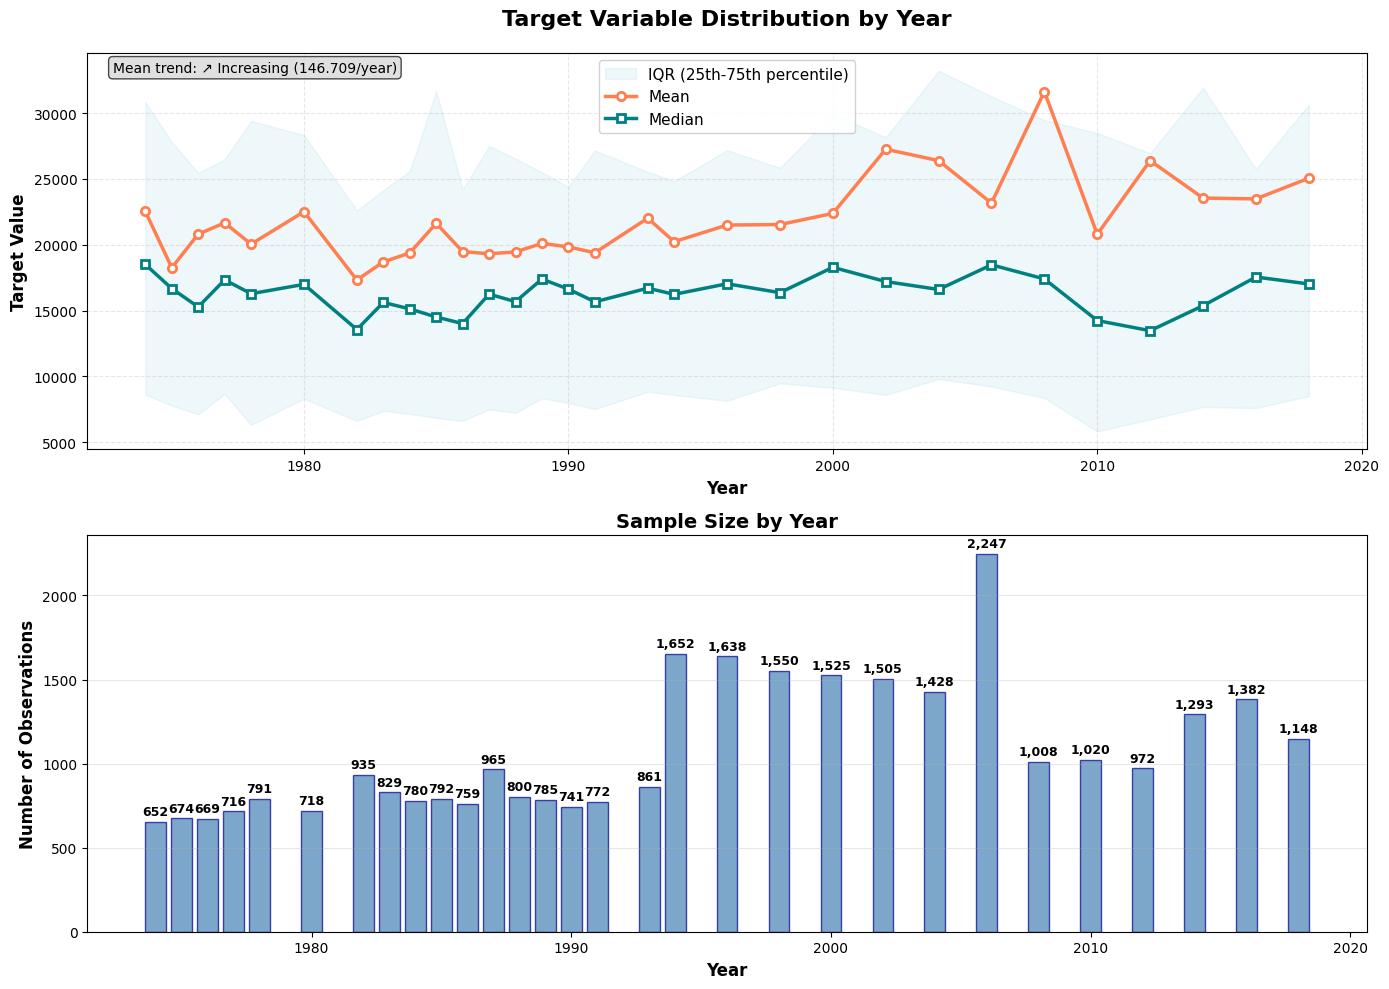

In [454]:
yearly_stats = X.groupby('year')['y'].agg([
    'mean', 'median', 'std', 'count', 
    lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)
]).reset_index()
yearly_stats.columns = ['year', 'mean', 'median', 'std', 'count', 'q25', 'q75']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.fill_between(yearly_stats['year'], 
                yearly_stats['q25'], yearly_stats['q75'],
                alpha=0.2, color='lightblue', label='IQR (25th-75th percentile)')

line1 = ax1.plot(yearly_stats['year'], yearly_stats['mean'], 
                marker='o', linewidth=2.5, markersize=6, 
                color='coral', label='Mean', markerfacecolor='white', 
                markeredgewidth=2, markeredgecolor='coral')

line2 = ax1.plot(yearly_stats['year'], yearly_stats['median'], 
                marker='s', linewidth=2.5, markersize=6, 
                color='teal', label='Median', markerfacecolor='white',
                markeredgewidth=2, markeredgecolor='teal')

ax1.set_title('Target Variable Distribution by Year', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Target Value', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, framealpha=0.9)

if len(yearly_stats) > 1:
    mean_trend = np.polyfit(yearly_stats['year'], yearly_stats['mean'], 1)[0]
    trend_text = f"Mean trend: {'↗️ Increasing' if mean_trend > 0 else '↘️ Decreasing'} ({mean_trend:.3f}/year)"
    ax1.text(0.02, 0.98, trend_text, transform=ax1.transAxes, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7),
            verticalalignment='top', fontsize=10)

bars = ax2.bar(yearly_stats['year'], yearly_stats['count'], 
               alpha=0.7, color='steelblue', edgecolor='darkblue', linewidth=1)
ax2.set_title('Sample Size by Year', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Observations', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, yearly_stats['count']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(yearly_stats['count'])*0.01,
            f'{int(count):,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()

print("=== YEARLY TARGET STATISTICS ===")
print(yearly_stats.round(3))

print(f"\n=== KEY INSIGHTS ===")
print(f"Year range: {yearly_stats['year'].min()} - {yearly_stats['year'].max()}")
print(f"Total observations: {yearly_stats['count'].sum():,}")
print(f"Mean across all years: {yearly_stats['mean'].mean():.3f}")
print(f"Coefficient of variation (mean): {yearly_stats['mean'].std() / yearly_stats['mean'].mean():.3f}")

if len(yearly_stats) > 1:
    yearly_stats['mean_change'] = yearly_stats['mean'].pct_change() * 100
    yearly_stats['median_change'] = yearly_stats['median'].pct_change() * 100
    
    print(f"Largest year-over-year increase (mean): {yearly_stats['mean_change'].max():.2f}%")
    print(f"Largest year-over-year decrease (mean): {yearly_stats['mean_change'].min():.2f}%")

plt.show()

<Axes: >

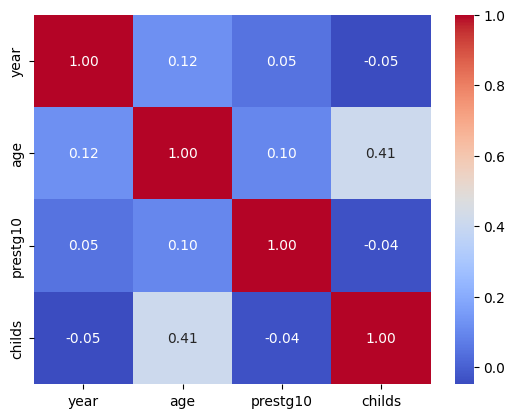

In [455]:
sns.heatmap(X_train.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

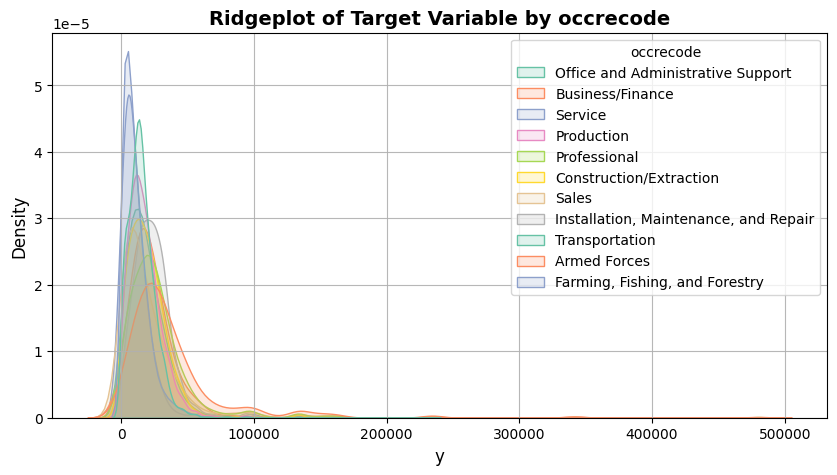

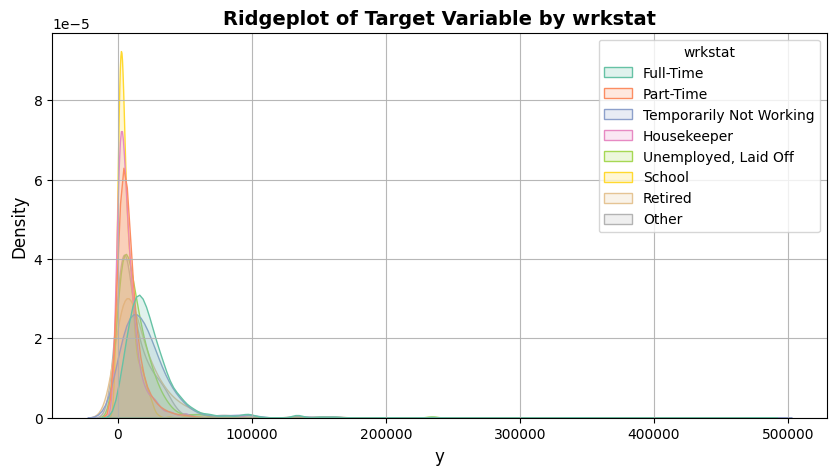

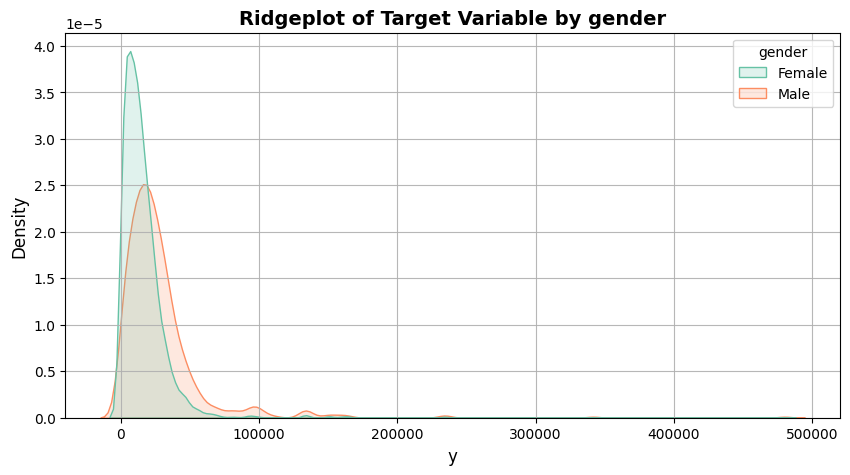

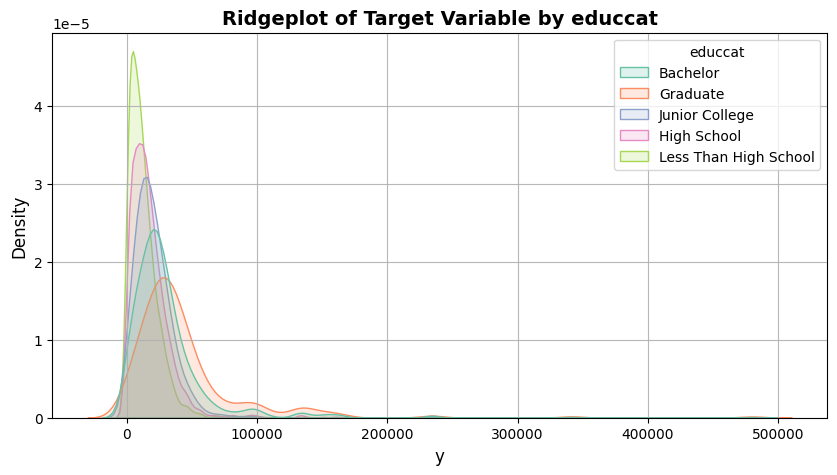

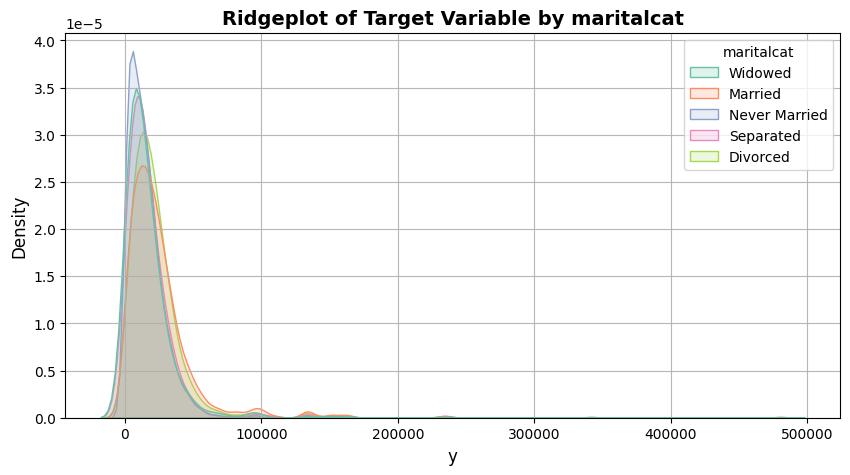

In [456]:
for col in X_train.select_dtypes(include=["object"]).columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=X, x='y', hue=col, fill=True, common_norm=False, alpha=0.2, palette='Set2')
    plt.title(f'Ridgeplot of Target Variable by {col}', fontsize=14, fontweight='bold')
    plt.xlabel('y', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True, alpha=0.9)
    plt.show()

In [457]:
X_train['age_bin'] = pd.cut(X_train['age'], bins=[17, 30, 50, 100], labels=['18-30', '31-50', '51+'])
X_test['age_bin'] = pd.cut(X_test['age'], bins=[17, 30, 50, 100], labels=['18-30', '31-50', '51+'])
max_observations['age_bin'] = pd.cut(max_observations['age'], bins=[17, 30, 50, 100], labels=['18-30', '31-50', '51+'])

X_train['childs_bin'] = pd.cut(X_train['childs'], bins=[-1, 2, 5, 20], labels=['0-2', '3-5', '6+'])
X_test['childs_bin'] = pd.cut(X_test['childs'], bins=[-1, 2, 5, 20], labels=['0-2', '3-5', '6+'])
max_observations['childs_bin'] = pd.cut(max_observations['childs'], bins=[-1, 2, 5, 20], labels=['0-2', '3-5', '6+'])

X_train['prestg10_bin'] = pd.cut(X_train['prestg10'], bins=[0, 30, 50, 100], labels=['16-30', '31-50', '51+'])
X_test['prestg10_bin'] = pd.cut(X_test['prestg10'], bins=[0, 30, 50, 100], labels=['16-30', '31-50', '51+'])
max_observations['prestg10_bin'] = pd.cut(max_observations['prestg10'], bins=[0, 30, 50, 100], labels=['16-30', '31-50', '51+'])

for col in X_train.select_dtypes(include=["category"]).columns:
    X_train[col] = X_train[col].astype("object")

for col in X_test.select_dtypes(include=["category"]).columns:
    X_test[col] = X_test[col].astype("object")

for col in max_observations.select_dtypes(include=["category"]).columns:
    max_observations[col] = max_observations[col].astype("object")


In [458]:
from scipy.stats import chi2_contingency
cat_cols = X_train.select_dtypes(include=["object"]).columns

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))    
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        table = pd.crosstab(X_train[cat_cols[i]], X_train[cat_cols[j]])
        v = cramers_v(table)
        print(f"{cat_cols[i]} vs {cat_cols[j]} : Cramér's V = {v:.3f}")


occrecode vs wrkstat : Cramér's V = 0.096
occrecode vs gender : Cramér's V = 0.426
occrecode vs educcat : Cramér's V = 0.306
occrecode vs maritalcat : Cramér's V = 0.071
occrecode vs age_bin : Cramér's V = 0.095
occrecode vs childs_bin : Cramér's V = 0.067
occrecode vs prestg10_bin : Cramér's V = 0.566
wrkstat vs gender : Cramér's V = 0.227
wrkstat vs educcat : Cramér's V = 0.074
wrkstat vs maritalcat : Cramér's V = 0.115
wrkstat vs age_bin : Cramér's V = 0.221
wrkstat vs childs_bin : Cramér's V = 0.068
wrkstat vs prestg10_bin : Cramér's V = 0.112
gender vs educcat : Cramér's V = 0.070
gender vs maritalcat : Cramér's V = 0.145
gender vs age_bin : Cramér's V = 0.017
gender vs childs_bin : Cramér's V = 0.007
gender vs prestg10_bin : Cramér's V = 0.017
educcat vs maritalcat : Cramér's V = 0.064
educcat vs age_bin : Cramér's V = 0.125
educcat vs childs_bin : Cramér's V = 0.135
educcat vs prestg10_bin : Cramér's V = 0.391
maritalcat vs age_bin : Cramér's V = 0.346
maritalcat vs childs_bin :

In [459]:
X_train["occrecode_gender"] = X_train["occrecode"].astype(str) + "_" + X_train["gender"].astype(str)
X_train["occrecode_educcat"] = X_train["occrecode"].astype(str) + "_" + X_train["educcat"].astype(str)
X_train["wrkstat_gender"] = X_train["wrkstat"].astype(str) + "_" + X_train["gender"].astype(str)
X_train["occrecode_prestg10_bin"] = X_train["occrecode"].astype(str) + "_" + X_train["prestg10_bin"].astype(str)
X_train["educcat_prestg10_bin"] = X_train["educcat"].astype(str) + "_" + X_train["prestg10_bin"].astype(str)
X_train["maritalcat_age_bin"] = X_train["maritalcat"].astype(str) + "_" + X_train["age_bin"].astype(str)

X_test["occrecode_gender"] = X_test["occrecode"].astype(str) + "_" + X_test["gender"].astype(str)
X_test["occrecode_educcat"] = X_test["occrecode"].astype(str) + "_" + X_test["educcat"].astype(str)
X_test["wrkstat_gender"] = X_test["wrkstat"].astype(str) + "_" + X_test["gender"].astype(str)
X_test["occrecode_prestg10_bin"] = X_test["occrecode"].astype(str) + "_" + X_test["prestg10_bin"].astype(str)
X_test["educcat_prestg10_bin"] = X_test["educcat"].astype(str) + "_" + X_test["prestg10_bin"].astype(str)
X_test["maritalcat_age_bin"] = X_test["maritalcat"].astype(str) + "_" + X_test["age_bin"].astype(str)

max_observations["occrecode_gender"] = max_observations["occrecode"].astype(str) + "_" + max_observations["gender"].astype(str)
max_observations["occrecode_educcat"] = max_observations["occrecode"].astype(str) + "_" + max_observations["educcat"].astype(str)
max_observations["wrkstat_gender"] = max_observations["wrkstat"].astype(str) + "_" + max_observations["gender"].astype(str)
max_observations["occrecode_prestg10_bin"] = max_observations["occrecode"].astype(str) + "_" + max_observations["prestg10_bin"].astype(str)
max_observations["educcat_prestg10_bin"] = max_observations["educcat"].astype(str) + "_" + max_observations["prestg10_bin"].astype(str)
max_observations["maritalcat_age_bin"] = max_observations["maritalcat"].astype(str) + "_" + max_observations["age_bin"].astype(str)


In [460]:
def fe_log(X, cols):
    for col in cols:
        X[f"{col}_log"] = np.log1p(X[col])
    return X

X_train = fe_log(X_train, X_train.select_dtypes(include=["number"]).columns)
X_test = fe_log(X_test, X_test.select_dtypes(include=["number"]).columns)
max_observations = fe_log(max_observations, max_observations.select_dtypes(include=["number"]).columns)

In [461]:
for col in X_train.select_dtypes(include=["object"]).columns:
    X_train[col] = X_train[col].str.replace(" ", "_")
    X_test[col] = X_test[col].str.replace(" ", "_")
    max_observations[col] = max_observations[col].str.replace(" ", "_")

In [462]:
X = X_train.copy()
X['y'] = y_train
X.head()

,year,age,occrecode,prestg10,childs,wrkstat,gender,educcat,maritalcat,age_bin,...,occrecode_educcat,wrkstat_gender,occrecode_prestg10_bin,educcat_prestg10_bin,maritalcat_age_bin,year_log,age_log,prestg10_log,childs_log,y
0,2002,31.0,Office_and_Administrative_Support,38.0,0.0,Full-Time,Female,Bachelor,Widowed,31-50,...,Office_and_Administrative_Support_Bachelor,Full-Time_Female,Office_and_Administrative_Support_31-50,Bachelor_31-50,Widowed_31-50,7.602401,3.465736,3.663562,0.000000,23463.75
1,2004,51.0,Business/Finance,52.0,2.0,Full-Time,Female,Graduate,Married,51+,...,Business/Finance_Graduate,Full-Time_Female,Business/Finance_51+,Graduate_51+,Married_51+,7.603399,3.951244,3.970292,1.098612,27171.00
2,1994,30.0,Service,48.0,2.0,Full-Time,Female,Junior_College,Never_Married,18-30,...,Service_Junior_College,Full-Time_Female,Service_31-50,Junior_College_31-50,Never_Married_18-30,7.598399,3.433987,3.891820,1.098612,14325.00
3,1980,45.0,Production,35.0,0.0,Full-Time,Female,High_School,Separated,31-50,...,Production_High_School,Full-Time_Female,Production_31-50,High_School_31-50,Separated_31-50,7.591357,3.828641,3.583519,0.000000,16994.00
4,2006,27.0,Professional,46.0,1.0,Full-Time,Female,Bachelor,Married,18-30,...,Professional_Bachelor,Full-Time_Female,Professional_31-50,Bachelor_31-50,Married_18-30,7.604396,3.332205,3.850148,0.693147,18476.25


In [463]:
X.drop(columns=['year_log'], errors='ignore', inplace=True)
max_observations.drop(columns=['year_log', 'y_log'], errors='ignore', inplace=True)
X_test.drop(columns=['year_log'], errors='ignore', inplace=True)

In [464]:
def oof_target_encode(df, cols, target, n_splits=10, smoothing=15):
    df = df.copy().reset_index(drop=False)
    global_mean = df[target].mean()
    oof = pd.DataFrame(index=df['index'])
    final_maps = {}
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for col in cols:
        oof_col = pd.Series(index=df['index'], dtype=float)
        
        for train_idx, val_idx in kf.split(df):
            tr = df.iloc[train_idx]
            val = df.iloc[val_idx]
            
            stats = tr.groupby(col)[target].agg(['mean', 'count'])
            counts = stats['count']
            means = stats['mean']
            
            smooth = (counts * means + smoothing * global_mean) / (counts + smoothing)
            
            #oof_col.iloc[val.index] = val[col].map(smooth).fillna(global_mean).values
            oof_col.loc[val['index']] = val[col].map(smooth).fillna(global_mean).values
        
        oof[col] = oof_col
        
        stats_full = df.groupby(col)[target].agg(['mean', 'count'])
        counts = stats_full['count']
        means = stats_full['mean']
        final_map = ((counts * means + smoothing * global_mean) / (counts + smoothing)).to_dict()
        final_maps[col] = final_map
    
    oof = oof.sort_index()
    
    return oof, final_maps, global_mean

oof_target_encode(X, X.select_dtypes(include=["object", "category"]).columns.tolist(), 'y')[0]

,occrecode,wrkstat,gender,educcat,maritalcat,age_bin,childs_bin,prestg10_bin,occrecode_gender,occrecode_educcat,wrkstat_gender,occrecode_prestg10_bin,educcat_prestg10_bin,maritalcat_age_bin
index,,,,,,,,,,,,,,
0,15631.239417,26301.413867,15971.082963,31010.785637,16944.294111,25058.555018,21857.542520,19688.288899,14352.643546,20315.922850,19461.606572,15812.025690,28388.280296,18444.727089
1,38270.534643,26257.273211,16045.702774,44466.635641,25696.168809,26196.669035,21988.571437,33656.018404,27469.688281,56455.348270,19488.760302,42864.941747,45451.946904,29423.117941
2,11509.933063,26345.784342,16051.355256,21598.298971,15960.346554,13213.031032,21979.767074,19779.518458,8829.857346,15346.361335,19509.234125,11140.519660,21379.542224,11700.508701
3,18197.878720,26398.755518,16069.553432,17838.412508,18197.522403,25252.253171,21991.783774,19706.021814,11887.601431,18839.111483,19604.635937,18934.473394,17943.553672,19459.773028
4,28241.265220,26301.413867,15971.082963,31010.785637,25649.710051,13113.653256,21857.542520,19688.288899,20835.088766,26452.605179,19461.606572,18965.482054,28388.280296,15294.470790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31602,38294.281535,26315.959120,15910.399305,30833.433413,25790.923697,25192.714364,21908.331255,19636.867807,27196.247525,44224.135140,19410.078020,33053.093278,28315.756144,27286.562278
31603,11438.904412,26207.803293,15969.076279,13202.347866,17750.234802,26177.719798,21866.122907,19617.010837,8765.135606,8057.318207,19447.708595,11009.853559,14330.235253,19899.949720
31604,20117.696421,26315.959120,28519.999287,17812.306458,25790.923697,25192.714364,21908.331255,19636.867807,20311.655864,21097.387638,31941.750459,21349.195538,17962.017634,27286.562278


In [465]:
oof, final_maps, global_mean = oof_target_encode(
    X, 
    X.select_dtypes(include=["object"]).columns.tolist(), 
    'y'
)

def apply_target_encoding(X_test, final_maps, global_mean, cols=None):
    X_test = X_test.copy()
    if cols is None:
        cols = list(final_maps.keys())
    for col in cols:
        if col not in X_test.columns:
            continue
        mapping = final_maps.get(col, {})
        X_test[col] = X_test[col].map(mapping).fillna(global_mean)
    return X_test

X = apply_target_encoding(X, final_maps, global_mean)
max_observations = apply_target_encoding(max_observations, final_maps, global_mean)
X_test = apply_target_encoding(X_test, final_maps, global_mean)

In [466]:
X.columns

Index(['year', 'age', 'occrecode', 'prestg10', 'childs', 'wrkstat', 'gender',
       'educcat', 'maritalcat', 'age_bin', 'childs_bin', 'prestg10_bin',
       'occrecode_gender', 'occrecode_educcat', 'wrkstat_gender',
       'occrecode_prestg10_bin', 'educcat_prestg10_bin', 'maritalcat_age_bin',
       'age_log', 'prestg10_log', 'childs_log', 'y'],
      dtype='object')

In [467]:
X_train = X.drop(columns=['y'])

In [468]:
from xgboostlss.distributions import *
from xgboostlss.distributions.distribution_utils import DistributionClass

Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


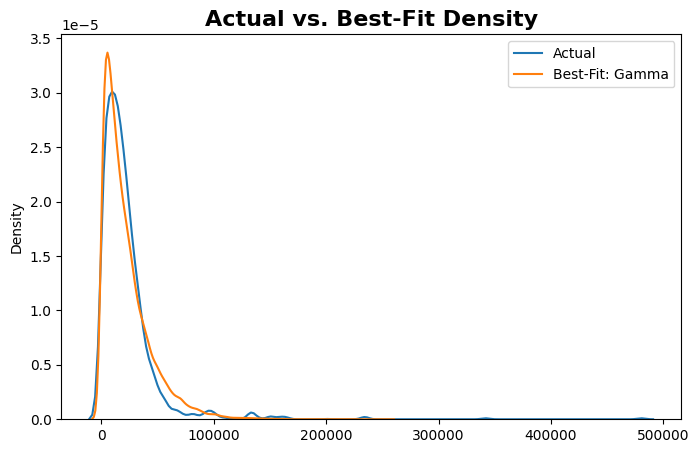

,nll,distribution
rank,,
1,347828.406250,Gamma
2,347967.377507,Weibull
3,348958.157585,LogNormal
4,351888.157281,Gumbel
5,354399.939464,Cauchy
6,368813.049104,Gaussian
7,368918.242679,StudentT
8,369896.498062,Laplace


In [469]:
from scipy.stats import boxcox, yeojohnson
xgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

dist_nll = xgblss_dist_class.dist_select(target=y_train.values, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 5))
dist_nll

In [470]:
import multiprocessing
import xgboost as xgb
from xgboostlss.distributions.Gamma import *
from xgboostlss.distributions.Weibull import  *
from xgboostlss.model import *

In [471]:
n_cpu = multiprocessing.cpu_count()

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

In [472]:
xgblss = XGBoostLSS(Gamma(stabilization="L2", response_fn="exp", loss_fn="crps"))

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from xgboostlss.model import XGBoostLSS
from xgboostlss.distributions.Gamma import Gamma
from scipy.stats import gamma
from typing import Dict, Any, Tuple, List
import torch

def crps_gamma(y_true: np.ndarray, concentration: np.ndarray, rate: np.ndarray) -> float:
    """Calculate CRPS for Gamma distribution predictions."""
    y_true = np.asarray(y_true)
    concentration = np.asarray(concentration)
    rate = np.asarray(rate)
    
    scale = 1.0 / rate
    
    crps_values = []
    for i in range(len(y_true)):
        samples = np.random.gamma(concentration[i], scale[i], 1000)
        term1 = np.mean(np.abs(samples - y_true[i]))
        term2 = 0.5 * np.mean(np.abs(samples[:, np.newaxis] - samples[np.newaxis, :]))
        crps_values.append(term1 - term2)
    
    return np.mean(crps_values)


def nested_cv_xgblss(X: pd.DataFrame,
                     y: np.ndarray,
                     param_dict: Dict[str, Any],
                     outer_folds: int = 5,
                     inner_folds: int = 5,
                     num_boost_round: int = 500,
                     early_stopping_rounds: int = 30,
                     max_minutes: int = 180,
                     n_trials: int = 20,
                     random_state: int = 123) -> Dict[str, Any]:
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    
    # Ensure y is a numpy array
    if isinstance(y, pd.Series):
        y = y.values
    elif isinstance(y, pd.DataFrame):
        y = y.values.ravel()
    y = np.asarray(y)
    
    # Initialize outer CV
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
    
    # Storage for results
    oof_predictions = np.zeros((len(y), 2))  # [concentration, rate]
    outer_scores = []
    best_params_per_fold = []
    best_rounds_per_fold = []
    
    print("=" * 80)
    print(f"Starting Nested Cross-Validation")
    print(f"Outer folds: {outer_folds} | Inner folds: {inner_folds}")
    print("=" * 80)
    
    # Outer loop: Performance estimation
    for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n{'='*80}")
        print(f"OUTER FOLD {outer_fold + 1}/{outer_folds}")
        print(f"{'='*80}")
        
        X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
        y_train_outer, y_test_outer = y[train_idx], y[test_idx]
        
        print(f"Train size: {len(train_idx)} | Test size: {len(test_idx)}")
        
        # Inner loop: Hyperparameter optimization
        print(f"\n--- Inner CV: Hyperparameter Optimization ---")
        
        dtrain_outer = xgb.DMatrix(X_train_outer, label=y_train_outer)
        
        xgblss_outer = XGBoostLSS(
            Gamma(stabilization="L2",
                  response_fn="exp",
                  loss_fn="crps")
        )
        
        # Hyperparameter optimization using inner CV
        opt_param = xgblss_outer.hyper_opt(
            param_dict,
            dtrain_outer,
            num_boost_round=num_boost_round,
            nfold=inner_folds,
            early_stopping_rounds=early_stopping_rounds,
            max_minutes=max_minutes,
            n_trials=n_trials,
            silence=False,
            seed=random_state + outer_fold,  # Different seed per outer fold
            hp_seed=random_state + outer_fold
        )
        
        # Extract optimized parameters
        opt_params = opt_param.copy()
        n_rounds = opt_params["opt_rounds"]
        del opt_params["opt_rounds"]
        
        best_params_per_fold.append(opt_params.copy())
        best_rounds_per_fold.append(n_rounds)
        
        print(f"\nBest parameters for outer fold {outer_fold + 1}:")
        print(f"  Boosting rounds: {n_rounds}")
        for key, value in opt_params.items():
            print(f"  {key}: {value}")
        
        # Train final model on outer training set with optimized parameters
        print(f"\n--- Training final model on outer train set ---")
        
        xgblss_final = XGBoostLSS(
            Gamma(stabilization="L2",
                  response_fn="exp",
                  loss_fn="crps")
        )
        
        dtest_outer = xgb.DMatrix(X_test_outer, label=y_test_outer)
        
        xgblss_final.train(
            params=opt_params,
            dtrain=dtrain_outer,
            num_boost_round=n_rounds,
            evals=[(dtrain_outer, 'train'), (dtest_outer, 'test')],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=50
        )
        
        # Predict on outer test set
        fold_pred_params = xgblss_final.predict(
            dtest_outer,
            pred_type="parameters"
        )
        
        # Store OOF predictions
        oof_predictions[test_idx, 0] = fold_pred_params.iloc[:, 0].values  # concentration
        oof_predictions[test_idx, 1] = fold_pred_params.iloc[:, 1].values  # rate
        
        # Calculate CRPS for this outer fold
        fold_crps = crps_gamma(
            y_test_outer,
            fold_pred_params.iloc[:, 0].values,
            fold_pred_params.iloc[:, 1].values
        )
        
        outer_scores.append(fold_crps)
        
        print(f"\n{'='*80}")
        print(f"OUTER FOLD {outer_fold + 1} RESULTS:")
        print(f"  CRPS: {fold_crps:.6f}")
        print(f"{'='*80}")
    
    mean_crps = np.mean(outer_scores)
    std_crps = np.std(outer_scores)
    
    overall_oof_crps = crps_gamma(
        y,
        oof_predictions[:, 0],
        oof_predictions[:, 1]
    )
    
    consensus_params = {}
    consensus_rounds = int(np.median(best_rounds_per_fold))
    
    param_names = best_params_per_fold[0].keys()
    
    for param_name in param_names:
        param_values = [fold_params[param_name] for fold_params in best_params_per_fold]
        
        if isinstance(param_values[0], str):
            from collections import Counter
            consensus_params[param_name] = Counter(param_values).most_common(1)[0][0]
        else:
            consensus_params[param_name] = np.median(param_values)
    
    print(f"\n\n{'='*80}")
    print("NESTED CROSS-VALIDATION RESULTS")
    print(f"{'='*80}")
    print(f"Mean CRPS (across outer folds): {mean_crps:.6f} ± {std_crps:.6f}")
    print(f"Overall OOF CRPS: {overall_oof_crps:.6f}")
    print(f"\nIndividual outer fold scores:")
    for i, score in enumerate(outer_scores):
        print(f"  Fold {i+1}: {score:.6f}")
    
    print(f"\n{'='*80}")
    print("CONSENSUS HYPERPARAMETERS (median across folds)")
    print(f"{'='*80}")
    print(f"Boosting rounds: {consensus_rounds}")
    for param_name, param_value in consensus_params.items():
        print(f"  {param_name}: {param_value}")
    print(f"{'='*80}\n")
    
    return {
        'oof_predictions': oof_predictions,
        'outer_scores': outer_scores,
        'mean_score': mean_crps,
        'std_score': std_crps,
        'overall_oof_crps': overall_oof_crps,
        'best_params_per_fold': best_params_per_fold,
        'best_rounds_per_fold': best_rounds_per_fold,
        'consensus_params': consensus_params,
        'consensus_rounds': consensus_rounds
    }


if __name__ == "__main__":
    param_dict = {
        "eta":              ["float", {"low": 1e-5,   "high": 0.3,     "log": True}],
        "max_depth":        ["int",   {"low": 1,      "high": 8,    "log": False}],
        "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
        "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
        "reg_alpha":        ["float", {"low": 0,      "high": 5,     "log": False}],
        "reg_lambda":       ["float", {"low": 0.5,    "high": 5,     "log": True}],
        "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
        "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
        "booster":          ["categorical", ["gbtree"]],
        "tree_method":      ["categorical", ["auto", "approx", "hist"]],
    }
    
    results = nested_cv_xgblss(
        X=X_train,
        y=y_train,
        param_dict=param_dict,
        outer_folds=5,      # Outer folds for performance estimation
        inner_folds=5,      # Inner folds for hyperparameter tuning
        num_boost_round=500,
        early_stopping_rounds=30,
        max_minutes=180,
        n_trials=15,
        random_state=123
    )
    
    print(f"\nFinal Nested CV Score: {results['mean_score']:.6f} ± {results['std_score']:.6f}")
    
    oof_df = pd.DataFrame(
        results['oof_predictions'],
        columns=['concentration', 'rate']
    )
    print("\nOOF Predictions Summary:")
    print(oof_df.describe())
    
    print("\nBest boosting rounds per outer fold:")
    print(results['best_rounds_per_fold'])

[I 2025-10-08 18:14:01,044] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


Starting Nested Cross-Validation
Outer folds: 5 | Inner folds: 5

OUTER FOLD 1/5
Train size: 25285 | Test size: 6322

--- Inner CV: Hyperparameter Optimization ---


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-08 18:31:39,001] Trial 0 finished with value: 42382904.8 and parameters: {'eta': 0.013127347871638296, 'max_depth': 3, 'gamma': 1.5074442732613943e-06, 'subsample': 0.6410518152663129, 'reg_alpha': 3.5973448489278153, 'reg_lambda': 1.324574727142493, 'colsample_bytree': 0.9846113587076923, 'min_child_weight': 0.21231116392056626, 'booster': 'gbtree', 'tree_method': 'auto'}. Best is trial 0 with value: 42382904.8.
[I 2025-10-08 18:47:35,761] Trial 1 finished with value: 42343020.0 and parameters: {'eta': 0.01836724168457087, 'max_depth': 4, 'gamma': 3.741370722352163e-08, 'subsample': 0.5184354042643451, 'reg_alpha': 3.6899770286601785, 'reg_lambda': 0.7611350732746983, 'colsample_bytree': 0.34036140491799405, 'min_child_weight': 0.004864656779286272, 'booster': 'gbtree', 'tree_method': 'hist'}. Best is trial 1 with value: 42343020.0.
[I 2025-10-08 18:58:32,669] Trial 2 finished with value: 43082946.4 and parameters: {'eta': 0.01751758901521546, 'max_depth': 5, 'gamma': 0.086

[I 2025-10-08 21:18:21,781] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization



OUTER FOLD 1 RESULTS:
  CRPS: 7907.750532

OUTER FOLD 2/5
Train size: 25285 | Test size: 6322

--- Inner CV: Hyperparameter Optimization ---


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-08 21:20:01,800] Trial 0 finished with value: 56465502.4 and parameters: {'eta': 2.9844578168273424e-05, 'max_depth': 6, 'gamma': 0.003128880038521594, 'subsample': 0.5665929470087052, 'reg_alpha': 1.923529515220681, 'reg_lambda': 0.9396352712286403, 'colsample_bytree': 0.7343699275264586, 'min_child_weight': 0.00017028456247781016, 'booster': 'gbtree', 'tree_method': 'approx'}. Best is trial 0 with value: 56465502.4.
[I 2025-10-08 21:21:51,959] Trial 1 finished with value: 56435946.4 and parameters: {'eta': 3.5517775045086465e-05, 'max_depth': 4, 'gamma': 23.00894504293714, 'subsample': 0.5740791205787348, 'reg_alpha': 0.7008570382505591, 'reg_lambda': 0.5508566338625176, 'colsample_bytree': 0.7823970155569637, 'min_child_weight': 0.03857845920899696, 'booster': 'gbtree', 'tree_method': 'auto'}. Best is trial 1 with value: 56435946.4.
[I 2025-10-08 21:41:30,645] Trial 2 finished with value: 43987926.4 and parameters: {'eta': 0.003069870049968582, 'max_depth': 4, 'gamma': 2.

[I 2025-10-09 00:14:51,770] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization



OUTER FOLD 2 RESULTS:
  CRPS: 7949.878096

OUTER FOLD 3/5
Train size: 25286 | Test size: 6321

--- Inner CV: Hyperparameter Optimization ---


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-09 00:37:19,535] Trial 0 finished with value: 47048084.8 and parameters: {'eta': 0.0018564095606576118, 'max_depth': 1, 'gamma': 0.010618438912783459, 'subsample': 0.3060420217601279, 'reg_alpha': 0.6554257485535148, 'reg_lambda': 3.07265649332784, 'colsample_bytree': 0.6053488887519383, 'min_child_weight': 0.0002611041693753215, 'booster': 'gbtree', 'tree_method': 'auto'}. Best is trial 0 with value: 47048084.8.
[I 2025-10-09 00:39:50,629] Trial 1 finished with value: 55902923.2 and parameters: {'eta': 4.27023258082483e-05, 'max_depth': 8, 'gamma': 6.741705024297076e-08, 'subsample': 0.8780097801420017, 'reg_alpha': 2.6480780852670875, 'reg_lambda': 1.775132518666487, 'colsample_bytree': 0.8787688750670364, 'min_child_weight': 5.024733310098008e-07, 'booster': 'gbtree', 'tree_method': 'hist'}. Best is trial 0 with value: 47048084.8.
[I 2025-10-09 00:42:27,672] Trial 2 finished with value: 43025124.8 and parameters: {'eta': 0.15057435566180577, 'max_depth': 3, 'gamma': 0.000

[I 2025-10-09 03:06:36,353] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization



OUTER FOLD 3 RESULTS:
  CRPS: 8207.536215

OUTER FOLD 4/5
Train size: 25286 | Test size: 6321

--- Inner CV: Hyperparameter Optimization ---


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-09 03:13:10,479] Trial 0 finished with value: 56097492.0 and parameters: {'eta': 2.9571160344714227e-05, 'max_depth': 2, 'gamma': 6.906859433410585e-08, 'subsample': 0.2923828501368335, 'reg_alpha': 3.7386380987552825, 'reg_lambda': 1.2078575670395102, 'colsample_bytree': 0.66403613936205, 'min_child_weight': 3.426989649642558e-08, 'booster': 'gbtree', 'tree_method': 'hist'}. Best is trial 0 with value: 56097492.0.
[I 2025-10-09 03:20:09,045] Trial 1 finished with value: 42587140.8 and parameters: {'eta': 0.044108493484358725, 'max_depth': 3, 'gamma': 18.40801912577465, 'subsample': 0.2446656526626323, 'reg_alpha': 0.5833537653456511, 'reg_lambda': 1.2837282437396689, 'colsample_bytree': 0.6539070064070152, 'min_child_weight': 0.0019810691038665514, 'booster': 'gbtree', 'tree_method': 'auto'}. Best is trial 1 with value: 42587140.8.
[I 2025-10-09 03:31:44,692] Trial 2 finished with value: 42236593.6 and parameters: {'eta': 0.020302161698188725, 'max_depth': 8, 'gamma': 0.032

[I 2025-10-09 05:53:26,710] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization



OUTER FOLD 4 RESULTS:
  CRPS: 7937.023546

OUTER FOLD 5/5
Train size: 25286 | Test size: 6321

--- Inner CV: Hyperparameter Optimization ---


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-09 06:12:20,444] Trial 0 finished with value: 46899753.6 and parameters: {'eta': 0.002214447001253028, 'max_depth': 1, 'gamma': 6.104499802988973e-07, 'subsample': 0.8182325183623269, 'reg_alpha': 2.760744393535069, 'reg_lambda': 0.6098835273299508, 'colsample_bytree': 0.5531158056745326, 'min_child_weight': 0.4525211771721998, 'booster': 'gbtree', 'tree_method': 'hist'}. Best is trial 0 with value: 46899753.6.
[I 2025-10-09 06:15:24,943] Trial 1 finished with value: 56363629.6 and parameters: {'eta': 2.9493930880986786e-05, 'max_depth': 2, 'gamma': 7.14192202893435e-08, 'subsample': 0.7197249117143483, 'reg_alpha': 0.35693731664274364, 'reg_lambda': 1.4419922235141613, 'colsample_bytree': 0.9253521107047382, 'min_child_weight': 1.0178180291015975e-07, 'booster': 'gbtree', 'tree_method': 'hist'}. Best is trial 0 with value: 46899753.6.
[I 2025-10-09 06:18:42,013] Trial 2 finished with value: 56392904.0 and parameters: {'eta': 3.7234529655283265e-05, 'max_depth': 1, 'gamma': 

XGBoostError: Invalid Parameter format for max_depth expect int but value='1.0'

In [473]:
# CONSENSUS HYPERPARAMETERS (median across folds)
# Boosting rounds: 237
#   eta: 0.08781071870834031
#   max_depth: 1.0
#   gamma: 0.0004346342867875754
#   subsample: 0.9858364231791616
#   reg_alpha: 2.597425596299047
#   reg_lambda: 2.0505224575876357
#   colsample_bytree: 0.5903504866396314
#   min_child_weight: 0.06400375723534635
#   booster: gbtree
#   tree_method: auto

opt_params = {
    "eta": 0.08781071870834031,
    "max_depth": 1,
    "gamma": 0.0004346342867875754,
    "subsample": 0.9858364231791616,
    "reg_alpha": 2.597425596299047,
    "reg_lambda": 2.0505224575876357,
    "colsample_bytree": 0.5903504866396314,
    "min_child_weight": 0.06400375723534635,
    "booster": "gbtree",
    "tree_method": "auto",
    "opt_rounds": 237
}

In [ ]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 0.3,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 8,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "reg_alpha":              ["float", {"low": 0,      "high": 5,     "log": False}],
    "reg_lambda":             ["float", {"low": 0.5,    "high": 5,     "log": True}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    "tree_method":    ["categorical", ["auto", "approx", "hist"]],
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=500,        # Number of boosting iterations.
                             nfold=6,                    # Number of cv-folds.
                             early_stopping_rounds=30,   # Number of early-stopping rounds
                             max_minutes=180,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=20,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=123                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2025-10-04 12:23:28,848] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-04 12:35:36,264] Trial 0 finished with value: 27802366.333333332 and parameters: {'eta': 0.013127347871638296, 'max_depth': 3, 'gamma': 1.5074442732613943e-06, 'subsample': 0.6410518152663129, 'reg_alpha': 3.5973448489278153, 'reg_lambda': 1.324574727142493, 'colsample_bytree': 0.9846113587076923, 'min_child_weight': 0.21231116392056626, 'booster': 'gbtree', 'tree_method': 'auto'}. Best is trial 0 with value: 27802366.333333332.
[I 2025-10-04 12:49:18,399] Trial 1 finished with value: 27505886.0 and parameters: {'eta': 0.01836724168457087, 'max_depth': 4, 'gamma': 3.741370722352163e-08, 'subsample': 0.5184354042643451, 'reg_alpha': 3.6899770286601785, 'reg_lambda': 0.7611350732746983, 'colsample_bytree': 0.34036140491799405, 'min_child_weight': 0.004864656779286272, 'booster': 'gbtree', 'tree_method': 'hist'}. Best is trial 1 with value: 27505886.0.
[I 2025-10-04 13:00:07,710] Trial 2 finished with value: 27565779.666666668 and parameters: {'eta': 0.01751758901521546, 'max_d

In [334]:
#   Best trial:
#     Value: 42679722.666666664
#     Params: 
#     eta: 0.07560859083508131
#     max_depth: 3
#     gamma: 0.0004346342867875754
#     subsample: 0.988447828488564
#     reg_alpha: 2.597425596299047
#     reg_lambda: 2.0505224575876357
#     colsample_bytree: 0.29650293279225903
#     min_child_weight: 6.934185220081648
#     booster: gbtree
#     tree_method: auto
#     opt_rounds: 176


# Best trial:
#     Value: 27422091.666666668
#     Params: 
#     eta: 0.07560859083508131
#     max_depth: 3
#     gamma: 0.0004346342867875754
#     subsample: 0.988447828488564
#     reg_alpha: 2.597425596299047
#     reg_lambda: 2.0505224575876357
#     colsample_bytree: 0.29650293279225903
#     min_child_weight: 6.934185220081648
#     booster: gbtree
#     tree_method: auto
#     opt_rounds: 396
opt_params = {
    "eta": 0.07560859083508131,
    "max_depth": 3,
    "gamma": 0.0004346342867875754,
    "subsample": 0.988447828488564,
    "min_child_weight": 6.934185220081648,
    "reg_alpha": 2.597425596299047,
    "reg_lambda": 2.0505224575876357,
    "colsample_bytree": 0.29650293279225903,
    "booster": "gbtree",
    "tree_method": "auto",
    "opt_rounds": 176
}

In [475]:
# opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

In [476]:
from scipy.stats import gamma

def crps_gamma(y_true: np.ndarray, concentration: np.ndarray, rate: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    concentration = np.asarray(concentration)
    rate = np.asarray(rate)
    
    scale = 1.0 / rate
    from scipy.special import gamma as gamma_func, gammainc
    
    F_y = gamma.cdf(y_true, a=concentration, scale=scale)
    
    mean = concentration * scale
    
    crps_values = []
    for i in range(len(y_true)):
        samples = np.random.gamma(concentration[i], scale[i], 1000)
        term1 = np.mean(np.abs(samples - y_true[i]))
        term2 = 0.5 * np.mean(np.abs(samples[:, np.newaxis] - samples[np.newaxis, :]))
        
        crps_values.append(term1 - term2)
    
    return np.mean(crps_values)


def crps_weibull(y_true: np.ndarray, concentration: np.ndarray, scale: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    concentration = np.asarray(concentration)
    scale = np.asarray(scale)
    
    from scipy.stats import weibull_min
    
    crps_values = []
    for i in range(len(y_true)):
        samples = weibull_min.rvs(c=concentration[i], scale=scale[i], size=1000)
        
        term1 = np.mean(np.abs(samples - y_true[i]))
        term2 = 0.5 * np.mean(np.abs(samples[:, np.newaxis] - samples[np.newaxis, :]))
        
        crps_values.append(term1 - term2)
    
    return np.mean(crps_values)

In [339]:
from scipy.special import gamma as gamma_func

from scipy.stats import weibull_min
from typing import Dict, Any, Tuple
import torch

def train_cv_with_oof(xgblss_model,
                      opt_params: Dict[str, Any], 
                      X_train: np.ndarray, 
                      y_train: np.ndarray,
                      n_rounds: int,
                      n_folds: int = 5,
                      random_state: int = 123) -> Tuple[np.ndarray, float, list]:
    
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    oof_predictions = np.zeros((len(y_train), 2))
    fold_scores = []
    
    print(f"Starting {n_folds}-fold cross-validation...")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"\n--- Fold {fold + 1}/{n_folds} ---")
        
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        dtrain_fold = xgb.DMatrix(X_fold_train, label=y_fold_train)
        dval_fold = xgb.DMatrix(X_fold_val, label=y_fold_val)
        
        xgblss_fold = XGBoostLSS(
            Gamma(stabilization="L2",
                  response_fn="exp",
                  loss_fn="crps"
                 )
        )
        
        print(f"Training fold {fold + 1}...")
        xgblss_fold.train(
            params=opt_params,
            dtrain=dtrain_fold,
            num_boost_round=n_rounds,
            evals=[(dtrain_fold, 'train'), (dval_fold, 'validation')],
            early_stopping_rounds=30,
            verbose_eval=50
        )
        
        fold_pred_params = xgblss_fold.predict(
            dval_fold, 
            pred_type="parameters"
        )
        
        oof_predictions[val_idx, 0] = fold_pred_params.iloc[:, 0].values  
        oof_predictions[val_idx, 1] = fold_pred_params.iloc[:, 1].values

        # scale_pred = fold_pred_params.iloc[:, 0].values      
        # concentration_pred = fold_pred_params.iloc[:, 1].values
        
        # oof_predictions[val_idx, 0] = scale_pred
        # oof_predictions[val_idx, 1] = concentration_pred

        fold_crps = crps_gamma(
            y_fold_val,
            fold_pred_params.iloc[:, 0].values, 
            fold_pred_params.iloc[:, 1].values  
        )
        
        fold_scores.append(fold_crps)
        print(f"Fold {fold + 1} CRPS: {fold_crps:.6f}")

    mean_crps = crps_gamma(
        y_train,
        oof_predictions[:, 0],
        oof_predictions[:, 1]
    )
    
    print(f"\n=== Cross-Validation Results ===")
    print(f"Mean CRPS across folds: {np.mean(fold_scores):.6f}")
    print(f"Std CRPS across folds: {np.std(fold_scores):.6f}")
    print(f"Overall OOF CRPS: {mean_crps:.6f}")
    print(f"Individual fold scores: {fold_scores}")
    
    return oof_predictions, mean_crps, fold_scores

y_train = dtrain.get_label()

oof_preds, cv_score, fold_scores = train_cv_with_oof(
    xgblss_model=xgblss,
    opt_params=opt_params,
    X_train=X_train,
    y_train=y_train, 
    n_rounds=n_rounds,
    n_folds=6,
    random_state=123
)

print(f"\\nFinal CV CRPS Score: {cv_score:.6f}")

oof_df = pd.DataFrame(oof_preds, columns=['concentration', 'rate'])
print("\\nOOF Predictions Summary:")
print(oof_df.describe())
# k 123          42
# 3 7990.563731  8000.023088
# 4 7997.661658  8013.680341
# 5 7989.352705  8005.524561
# 6 7970.993408  7984.468779
# 7 8024.270602  7991.355755

# Without the top coded data
# k 123          42
# 3 5766.441988
# 4 5571.692850
# 5 5758.700931  5509.730068
# 6 5234.721436  5681.577711
# 7 5234.123197  5633.483168

Starting 6-fold cross-validation...

--- Fold 1/6 ---
Training fold 1...
[0]	train-crps:279314432.00000	validation-crps:55990768.00000
[50]	train-crps:218643888.00000	validation-crps:44156408.00000
[100]	train-crps:212267824.00000	validation-crps:43573592.00000
[150]	train-crps:207506848.00000	validation-crps:43070208.00000
[175]	train-crps:206391600.00000	validation-crps:43108348.00000
Fold 1 CRPS: 7908.856357

--- Fold 2/6 ---
Training fold 2...
[0]	train-crps:280621888.00000	validation-crps:55173940.00000
[50]	train-crps:219647600.00000	validation-crps:43848640.00000
[100]	train-crps:213404240.00000	validation-crps:43160892.00000
[150]	train-crps:208201104.00000	validation-crps:42922772.00000
[175]	train-crps:206930880.00000	validation-crps:42738400.00000
Fold 2 CRPS: 7829.906404

--- Fold 3/6 ---
Training fold 3...
[0]	train-crps:278252800.00000	validation-crps:57596200.00000
[50]	train-crps:218421648.00000	validation-crps:45376624.00000
[100]	train-crps:211053472.00000	validation-

In [477]:
xgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

In [478]:
xgblss.save_model("xgblss_gamma_model.json")

In [ ]:
from scipy.stats import gamma
import numpy as np

def crps_gamma(y_true: np.ndarray, concentration: np.ndarray, rate: np.ndarray) -> float:
    y_true = np.asarray(y_true).flatten()
    concentration = np.asarray(concentration).flatten()
    rate = np.asarray(rate).flatten()
    
    n = len(y_true)
    scale = 1.0 / rate
    
    crps_values = np.zeros(n)
    
    batch_size = 1000
    n_samples = 1000
    
    for i in range(0, n, batch_size):
        end_idx = min(i + batch_size, n)
        batch_size_actual = end_idx - i
        
        samples = np.random.gamma(
            concentration[i:end_idx, np.newaxis], 
            scale[i:end_idx, np.newaxis], 
            (batch_size_actual, n_samples)
        )
        
        for j in range(batch_size_actual):
            idx = i + j
            # E|X - y|
            term1 = np.mean(np.abs(samples[j] - y_true[idx]))
            # 0.5 * E|X - X'|
            term2 = 0.5 * np.mean(np.abs(samples[j, :, np.newaxis] - samples[j, np.newaxis, :]))
            crps_values[idx] = term1 - term2
    
    return np.mean(crps_values)

params = xgblss.predict(dtrain, pred_type="parameters")
crps_score = crps_gamma(
    y_train,
    params.iloc[:, 0].values,
    params.iloc[:, 1].values
)
print(f"CRPS: {crps_score}")

CRPS: 7948.453058594513


In [485]:
predictions = xgblss.predict(dtest, pred_type="samples", n_samples=1000)
arr = predictions.to_numpy()
np.save("predictions.npy", arr)